In [37]:
import pickle
import pandas as pd
import requests
from bs4 import BeautifulSoup
import sys
import os
from collections import defaultdict
import re
import json
from collections import Counter
import dateutil
from dateutil import parser
from collections import defaultdict
from __future__ import division
import datetime
%pylab inline
from numpy import arange
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [38]:
def parseint(string):
    string = str(string)
    return int(''.join([x for x in string if x.isdigit()]))

In [39]:
with open('movie_info_revised.p' ,'r') as picklefile:
    data = pickle.load(picklefile)

In [40]:
def date_helper(date):
    try:
        date = parser.parse(date)
        return True
    except: 
        pass
    return False

In [41]:
history_keys_dic = defaultdict(dict)
for key in data.keys():
    if 'sequel' in data[key]['keywords']:
        if date_helper(data[key]['date']):
            year = parser.parse(data[key]['date']).year
            history_keys_dic['count'][year]= history_keys_dic['count'].get(year, 0) + 1  
history_df = pd.DataFrame.from_dict(history_keys_dic)
start = pd.datetime(1980, 1, 1)
end = pd.datetime(2016, 1, 1)
x = pd.date_range(start, end, freq='A').year
history_df_years = history_df.reindex(x)
history_df = history_df_years.fillna(0)
history_df['rolling mean']=pd.rolling_mean(history_df['count'], 5).shift(+1)
history_df['difference from mean']=history_df['count']/history_df['rolling mean']

In [42]:
history_keys_dic

defaultdict(<type 'dict'>, {'count': {1972: 4, 1973: 9, 1974: 9, 1975: 10, 1976: 8, 1977: 16, 1978: 12, 1979: 9, 1980: 7, 1981: 7, 1982: 12, 1983: 14, 1984: 12, 1985: 15, 1986: 12, 1987: 24, 1988: 25, 1989: 25, 1990: 22, 1991: 19, 1992: 14, 1993: 21, 1994: 24, 1995: 15, 1996: 16, 1997: 22, 1998: 22, 1999: 8, 2000: 16, 2001: 13, 2002: 21, 2003: 25, 2004: 24, 2005: 19, 2006: 20, 2007: 25, 2008: 25, 2009: 19, 2010: 23, 2011: 24, 2012: 25, 2013: 26, 2014: 7, 2015: 22, 2016: 4}})

In [43]:
history_df

,count,rolling mean,difference from mean
1980,7,NaN,NaN
1981,7,NaN,NaN
1982,12,NaN,NaN
1983,14,NaN,NaN
1984,12,NaN,NaN
1985,15,10.4,1.442308
1986,12,12.0,1.000000
1987,24,13.0,1.846154
1988,25,15.4,1.623377
1989,25,17.6,1.420455


In [44]:
history_dic = defaultdict(dict)
for key in data.keys():
    if 'sequel' in data[key]['keywords']:
        if date_helper(data[key]['date']):
            year = parser.parse(data[key]['date']).year
            history_dic[year][key]= defaultdict(dict)
            history_dic[year][key]['date']= data[key]['date']
            history_dic[year][key]['screens']= data[key]['screens']
            history_dic[year][key]['opening']= data[key]['opening']
                #space_dic['space'][year].append(key,)

In [45]:
history_dic

defaultdict(<type 'dict'>, {1972: {'Trafic': defaultdict(<type 'dict'>, {'date': '11 December 1972', 'screens': 'Error', 'opening': 'N/A'}), 'The Life and Times of Judge Roy Bean': defaultdict(<type 'dict'>, {'date': '18 December 1972', 'screens': 'Error', 'opening': 'N/A'}), 'Nybyggarna': defaultdict(<type 'dict'>, {'date': '26 February 1972', 'screens': 'Error', 'opening': 'N/A'}), 'Dracula A.D. 1972': defaultdict(<type 'dict'>, {'date': '17 November 1972', 'screens': 'Error', 'opening': 'N/A'})}, 1973: {'Carry on Abroad': defaultdict(<type 'dict'>, {'date': '8 December 1973', 'screens': 'Error', 'opening': 'N/A'}), 'Scream Blacula Scream': defaultdict(<type 'dict'>, {'date': '27 June 1973', 'screens': 'Error', 'opening': 'N/A'}), 'O Lucky Man!': defaultdict(<type 'dict'>, {'date': '20 June 1973', 'screens': 'Error', 'opening': 'N/A'}), 'Holiday on the Buses': defaultdict(<type 'dict'>, {'date': '26 December 1973', 'screens': 'Error', 'opening': 'N/A'}), 'Battle for the Planet of the

In [46]:
def makedf(genre):
    frames = []
    years = []
    for year, movies in genre.items():
        years.append(year)
        frames.append(pd.DataFrame.from_dict(movies, orient='index'))
    genre = pd.concat(frames, keys=years)
    genre = genre[genre.screens != 'N/A']
    genre = genre[genre.screens != 'n/a']
    genre = genre[genre.screens != 'Error']
    genre = genre[genre.opening != 'N/A']
    genre = genre[genre.screens != '']
    genre = genre[genre.opening != '']
    genre = genre[genre.opening != 'n/a']
    genre = genre[genre.opening != 'Error']
    genre['opening'] = genre['opening'].map(lambda x: parseint(x))
    genre['screens'] = genre['screens'].map(lambda x: parseint(x))
    genre['date'] = genre['date'].map(lambda x: parser.parse(x))
    genre['normalized_opening']= genre['opening']/genre['screens']
    genre = genre[genre.normalized_opening < 20000]
    return genre

In [47]:
genre=makedf(history_dic)
pd.set_option('display.max_rows', 1000)
genre1 = genre[genre.screens > 50]
genre1 = genre1.reset_index()
genre1

,level_0,level_1,date,screens,opening,normalized_opening
0,1977,Exorcist II: The Heretic,1977-06-17,703,6735000,9580.369844
1,1977,The Spy Who Loved Me,1977-08-03,194,1347927,6948.077320
2,1978,Damien: Omen II,1978-06-09,525,3880880,7392.152381
3,1978,Jaws 2,1978-06-16,640,9866023,15415.660938
4,1979,Moonraker,1979-06-29,788,7108344,9020.741117
5,1979,Rocky II,1979-06-15,780,6390537,8192.996154
6,1979,Star Trek: The Motion Picture,1979-12-07,857,11926421,13916.477246
7,1980,Any Which Way You Can,1980-12-17,1541,8024663,5207.438676
8,1980,"Oh, God! Book II",1980-10-03,1033,3439846,3329.957406
9,1980,Smokey and the Bandit II,1980-08-15,1196,10883835,9100.196488


In [48]:
trend = genre1[281:316]

trend

,level_0,level_1,date,screens,opening,normalized_opening
281,2002,Analyze That,2002-12-06,2635,11034422,4187.636433
282,2002,Blade II,2002-03-22,2707,32528016,12016.260066
283,2002,Die Another Day,2002-11-22,3314,47072040,14203.995172
284,2002,Friday After Next,2002-11-22,1616,13010767,8051.217203
285,2002,Full Frontal,2002-08-02,208,739834,3556.894231
286,2002,Halloween: Resurrection,2002-07-12,1954,12292121,6290.747697
287,2002,Men in Black II,2002-07-03,3557,52148751,14660.880236
288,2002,Queen of the Damned,2002-02-22,2511,14757535,5877.154520
289,2002,Return to Never Land,2002-02-15,2605,11889631,4564.157774
290,2002,Spy Kids 2: Island of Lost Dreams,2002-08-07,3307,16711716,5053.436952


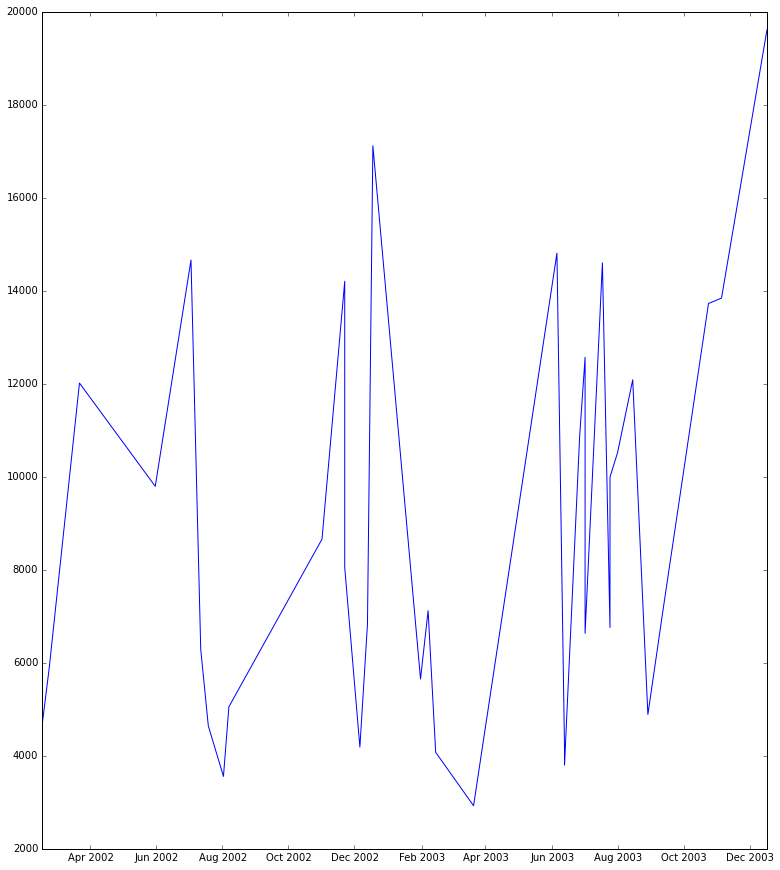

In [49]:
figure(figsize=(13,15))
trend = trend.sort(['date'])
plt.plot(trend['date'], trend['normalized_opening'])

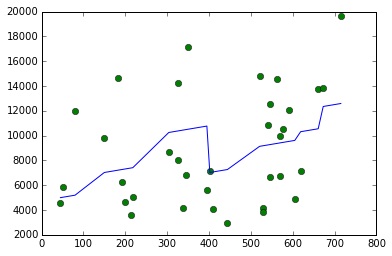

In [54]:
trend['time_delta']=trend['date'].apply(lambda x: str(x - parser.parse('2002-01-01')))
trend['time_delta_num'] = trend['time_delta'].str.replace(r'days[\s\S]+', '').apply(lambda x: int(x))

def sort_season(x):
    if x in [11, 12, 1]:
        return 'Winter'
    if x in [5, 6, 7, 8]:
        return 'Summer'
    if x in [9, 10,]:
        return 'Fall'
    if x in [2, 3, 4,]:
        return 'Spring'

trend['season']=trend['date'].apply(lambda x: sort_season(x.month))
from patsy import dmatrices
from patsy import dmatrix
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
#plot_data = trend
y, X = dmatrices('normalized_opening ~ time_delta_num + season ', data = trend, return_type= 'dataframe')
model = sm.OLS(y, X)
fitted = model.fit()
plot(X['time_delta_num'], y, 'go')
plot(X['time_delta_num'], fitted.fittedvalues, 'b')



In [51]:
model.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     normalized_opening   R-squared:                       0.177
Model:                            OLS   Adj. R-squared:                  0.068
Method:                 Least Squares   F-statistic:                     1.616
Date:                Thu, 08 Oct 2015   Prob (F-statistic):              0.196
Time:                        15:26:59   Log-Likelihood:                -339.79
No. Observations:                  35   AIC:                             689.6
Df Residuals:                      30   BIC:                             697.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
Intercept         1.717e+04   6077.039      2.826      0.008      4760.701  2.96e+04
season[T.Spring] -2055.0542   3936.736     -0.522      0.605     -1.01e+04  5984.833
season[T.Summer]  -621.6279   3330.764     -0.187      0.853     -7423.956  6180.700
season[T.Winter]  1728.9140   3501.398      0.494      0.625     -5421.894  8879.722
time_delta_num       5.6826      4.436      1.281      0.210        -3.378    14.743
==============================================================================
Omnibus:                        4.538   Durbin-Watson:                   1.969
Prob(Omnibus):                  0.103   Jarque-Bera (JB):                2.269
Skew:                           0.346   Prob(JB):                        0.322
Kurtosis:                       1.962   Cond. No.                     1.25e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.25e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [57]:

with open('sequel_df.p', 'w') as picklefile:
    pickle.dump(trend, picklefile)